In [12]:
from PIL import Image, ImageFilter
import numpy as np

img = Image.open('images/cat.jpg')
img = np.array(img)
np.shape(img)

(275, 184, 3)

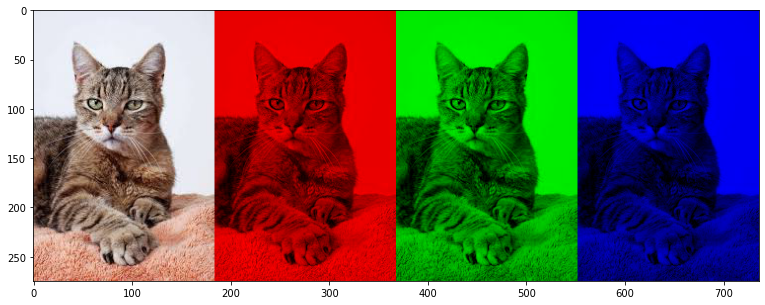

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(13, 5))

R, G, B = img * [1, 0, 0], img * [0, 1, 0], img * [0, 0, 1]
plt.imshow(np.concatenate([img, R, G, B], axis=1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'rgb->lab->rgb')

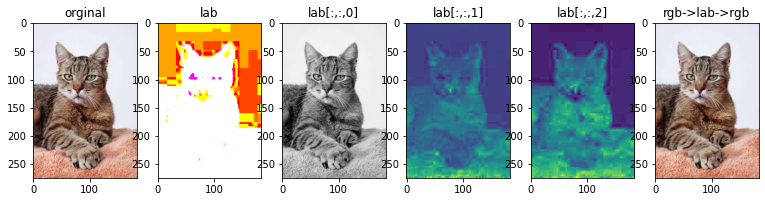

In [14]:
from skimage.color import rgb2lab, lab2rgb

lab = rgb2lab(img)
rgb = lab2rgb(lab)

plt.figure(figsize=(13, 5))
plt.subplot(1, 6, 1)
plt.title('orginal')
plt.imshow(img)

plt.subplot(1, 6, 2)
plt.imshow(np.array(lab))
plt.title('lab')

plt.subplot(1, 6, 3)
plt.imshow(lab[:, :, 0], cmap='gray')
plt.title('lab[:,:,0]')

plt.subplot(1, 6, 4)
plt.imshow(lab[:, :, 1])
plt.title('lab[:,:,1]')

plt.subplot(1, 6, 5)
plt.imshow(lab[:, :, 2])
plt.title('lab[:,:,2]')

plt.subplot(1, 6, 6)
plt.imshow(img / 255)
plt.title('rgb->lab->rgb')

In [15]:
np.shape(img), np.shape(lab), np.shape(rgb)

for x in range(3):
    print(np.shape(lab), lab[:, :, x].min(), '~', lab[:, :, x].max())

print('-' * 100)

tmp = np.array(lab) + [0, 128, 128]
for x in range(3):
    print(np.shape(tmp), tmp[:, :, x].min(), '~', tmp[:, :, x].max())

(275, 184, 3) 0.2543866689892553 ~ 99.92678386264787
(275, 184, 3) -9.626379369696236 ~ 43.87409664592001
(275, 184, 3) -9.027619515313656 ~ 38.32779196668377
----------------------------------------------------------------------------------------------------
(275, 184, 3) 0.2543866689892553 ~ 99.92678386264787
(275, 184, 3) 118.37362063030376 ~ 171.87409664592002
(275, 184, 3) 118.97238048468634 ~ 166.32779196668378


In [16]:
from PIL import Image

a = Image.open('images/cat.jpg')
np.shape(a)

(275, 184, 3)

(2, 4)


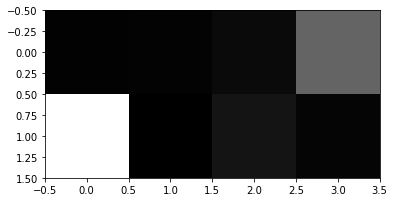

(2, 4, 1)


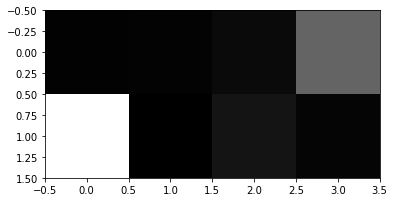

(2, 4, 3)


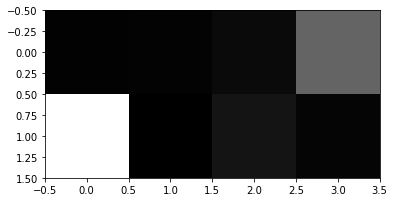

In [17]:
# 채널 수 상관없음 보여주기
# 채널 x
gray = [[2, 3, 10, 100], [255, 0, 20, 5]]
print(np.shape(gray))
plt.imshow(gray, cmap='gray')
plt.show()

# 채널 1
gray = [[[2], [3], [10], [100]], [[255], [0], [20], [5]]]
print(np.shape(gray))
plt.imshow(gray, cmap='gray')
plt.show()

# 채널 3
gray = [[[2, 2, 2], [3, 3, 3], [10, 10, 10], [100, 100, 100]],
        [[255, 255, 255], [0, 0, 0], [20, 20, 20], [5, 5, 5]]]
print(np.shape(gray))
plt.imshow(gray, cmap='gray')
plt.show()

In [18]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34

In [19]:
data = np.load('.npzs/pfcn.npz')
train_images = data['train_images']
test_images = data['test_images']

In [20]:
from skimage import color

train_gray_images = np.array(
    [color.rgb2gray(img).reshape((100, 75, 1)) for img in train_images])
test_gray_images = np.array(
    [color.rgb2gray(img).reshape((100, 75, 1)) for img in test_images])

print(train_gray_images.shape, test_gray_images.shape)

(1700, 100, 75, 1) (300, 100, 75, 1)


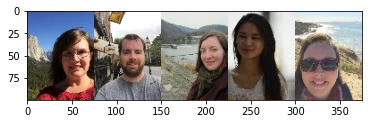

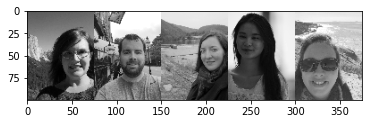

In [21]:
plt.imshow(np.hstack(train_images[:5]))
plt.show()

plt.imshow(np.hstack(train_gray_images[:5]), cmap='gray')
plt.show()

In [22]:
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape, MaxPool2D
from keras.models import Model
from keras.layers import BatchNormalization, Dropout, Activation, concatenate


def conv2d_block(x, channel):
    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def unet_color():
    inputs = Input((100, 75, 1))

    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D(2)(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D(2)(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D(2)(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D(2)(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv2d_block(p4, 256)

    u6 = Conv2DTranspose(128, 2, 2, padding="valid", output_padding=(0, 1))(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)

    u7 = Conv2DTranspose(64, 2, 2, padding="valid", output_padding=(1, 0))(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)

    u8 = Conv2DTranspose(32, 2, 2, padding="valid", output_padding=(0, 1))(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)

    u9 = Conv2DTranspose(16, 2, 2, padding="valid", output_padding=(0, 1))(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)

    outputs = Conv2D(3, 1, activation="sigmoid")(c9)
    model = Model(inputs, outputs)
    return model

In [23]:
model = unet_color()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 75, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 75, 16)  160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 75, 16)  64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 100, 75, 16)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [24]:
model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])
hist = model.fit(train_gray_images,
                 train_images,
                 validation_data=(test_gray_images, test_images),
                 epochs=50,
                 verbose=1)

Epoch 1/50
54/54 [==============================] - 13s 80ms/step - loss: 0.0261 - accuracy: 0.4820 - val_loss: 0.0650 - val_accuracy: 0.6868
Epoch 2/50
54/54 [==============================] - 2s 44ms/step - loss: 0.0108 - accuracy: 0.6086 - val_loss: 0.0626 - val_accuracy: 0.6886
Epoch 3/50
54/54 [==============================] - 2s 43ms/step - loss: 0.0090 - accuracy: 0.6217 - val_loss: 0.0546 - val_accuracy: 0.4548
Epoch 4/50
54/54 [==============================] - 2s 44ms/step - loss: 0.0083 - accuracy: 0.6265 - val_loss: 0.0469 - val_accuracy: 0.6666
Epoch 5/50
54/54 [==============================] - 2s 44ms/step - loss: 0.0079 - accuracy: 0.6349 - val_loss: 0.0418 - val_accuracy: 0.4058
Epoch 6/50
54/54 [==============================] - 2s 43ms/step - loss: 0.0076 - accuracy: 0.6349 - val_loss: 0.0318 - val_accuracy: 0.6507
Epoch 7/50
54/54 [==============================] - 2s 42ms/step - loss: 0.0074 - accuracy: 0.6395 - val_loss: 0.0230 - val_accuracy: 0.5919
Epoch 8/50
5

(1, 100, 75, 1)
(1, 100, 75, 3)


Text(0.5, 1.0, 'ai')

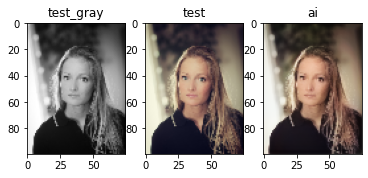

In [25]:
res = model.predict(test_gray_images[2:3])
print(test_gray_images[2:3].shape)
print(res.shape)

plt.subplot(1, 3, 1)
plt.imshow(test_gray_images[2], cmap='gray')
plt.title('test_gray')

plt.subplot(1, 3, 2)
plt.imshow(test_images[2])
plt.title('test')

plt.subplot(1, 3, 3)
plt.imshow(res[0])
plt.title('ai')

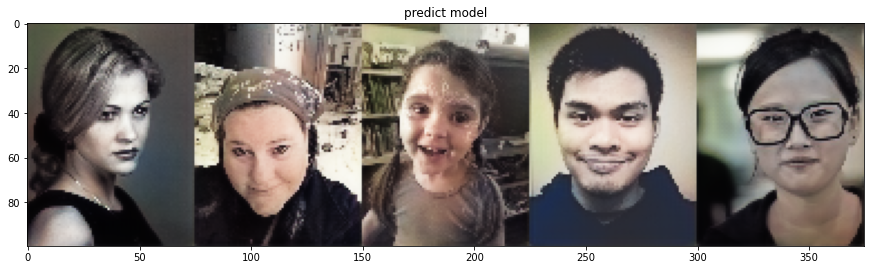

Text(0.5, 1.0, 'gray')

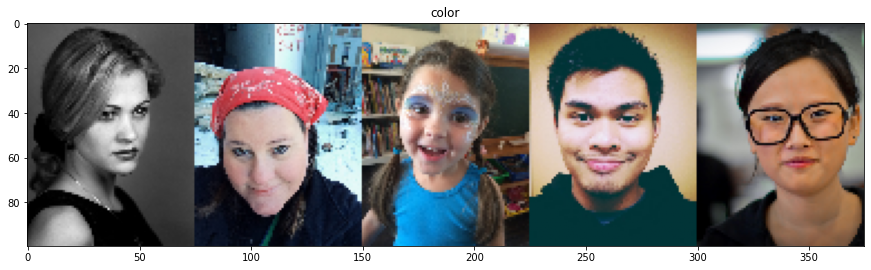

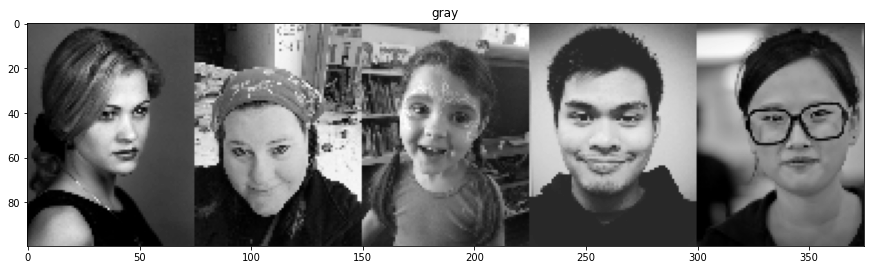

In [26]:
plt.figure(figsize=(15, 5))
five = model.predict(test_gray_images[10:15])

plt.imshow(np.hstack(five))
plt.title('predict model')
plt.show()

plt.figure(figsize=(15, 5))
plt.imshow(np.hstack(test_images[10:15]))
plt.title('color')

plt.figure(figsize=(15, 5))
plt.imshow(np.hstack(test_gray_images[10:15]), cmap='gray')
plt.title('gray')

In [27]:
train_lab_images = np.array([color.rgb2lab(img) for img in train_images])
test_lab_images = np.array([color.rgb2lab(img) for img in test_images])

In [28]:
train_lab_images = (train_lab_images + [0, 128, 128]) / [100., 255., 255.]
test_lab_images = (test_lab_images + [0, 128, 128]) / [100., 255., 255.]

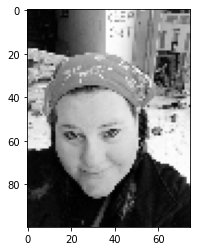

0.0 1.0
0.19397112017382181 0.8400303209378147
0.14128202093029715 0.8698299619820618


In [29]:
plt.imshow(test_lab_images[11][..., 0], cmap="gray")
plt.show()
#np.shape(test_lab_images),np.shape(test_lab_images)

print(train_lab_images[..., 0].min(), train_lab_images[..., 0].max())
print(train_lab_images[..., 1].min(), train_lab_images[..., 1].max())
print(train_lab_images[..., 2].min(), train_lab_images[..., 2].max())

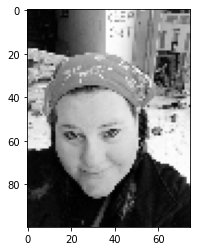

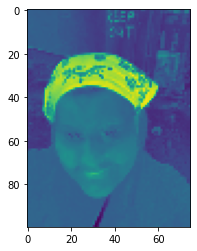

In [30]:
plt.imshow(test_lab_images[11][..., 0:1], cmap='gray')
plt.show()
plt.imshow(test_lab_images[11][..., 1:2])
plt.show()

In [31]:
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape, MaxPool2D
from keras.models import Model
from keras.layers import BatchNormalization, Dropout, Activation, concatenate

from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape, MaxPool2D
from keras.models import Model
from keras.layers import BatchNormalization, Dropout, Activation, concatenate


def conv2d_block(x, channel):
    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def unet_lab():
    inputs = Input((100, 75, 1))

    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D(2)(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D(2)(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D(2)(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D(2)(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv2d_block(p4, 256)

    u6 = Conv2DTranspose(128, 2, 2, padding="valid", output_padding=(0, 1))(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)

    u7 = Conv2DTranspose(64, 2, 2, padding="valid", output_padding=(1, 0))(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)

    u8 = Conv2DTranspose(32, 2, 2, padding="valid", output_padding=(0, 1))(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)

    u9 = Conv2DTranspose(16, 2, 2, padding="valid", output_padding=(0, 1))(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)

    outputs = Conv2D(2, 1, activation="sigmoid")(c9)
    model = Model(inputs, outputs)
    return model

In [32]:
model2 = unet_lab()
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 75, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 100, 75, 16)  160         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 100, 75, 16)  64          conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 100, 75, 16)  0           batch_normalization_18[0][0]     
____________________________________________________________________________________________

In [33]:
model2.compile(loss="mae", optimizer="adam", metrics=["accuracy"])
hist2 = model2.fit(train_lab_images[..., 0:1],
                   train_lab_images[..., 1:],
                   validation_data=(test_lab_images[...,
                                                    0:1], test_lab_images[...,
                                                                          1:]),
                   epochs=50,
                   verbose=1)

Epoch 1/50
54/54 [==============================] - 5s 51ms/step - loss: 0.0539 - accuracy: 0.5582 - val_loss: 0.0364 - val_accuracy: 0.5312
Epoch 2/50
54/54 [==============================] - 2s 41ms/step - loss: 0.0358 - accuracy: 0.5785 - val_loss: 0.0530 - val_accuracy: 0.5145
Epoch 3/50
54/54 [==============================] - 2s 41ms/step - loss: 0.0350 - accuracy: 0.5781 - val_loss: 0.0466 - val_accuracy: 0.5693
Epoch 4/50
54/54 [==============================] - 2s 42ms/step - loss: 0.0340 - accuracy: 0.5840 - val_loss: 0.0407 - val_accuracy: 0.5855
Epoch 5/50
54/54 [==============================] - 2s 42ms/step - loss: 0.0338 - accuracy: 0.5870 - val_loss: 0.0400 - val_accuracy: 0.5573
Epoch 6/50
54/54 [==============================] - 2s 42ms/step - loss: 0.0331 - accuracy: 0.6000 - val_loss: 0.0383 - val_accuracy: 0.5789
Epoch 7/50
54/54 [==============================] - 2s 42ms/step - loss: 0.0327 - accuracy: 0.6024 - val_loss: 0.0380 - val_accuracy: 0.6050
Epoch 8/50
54

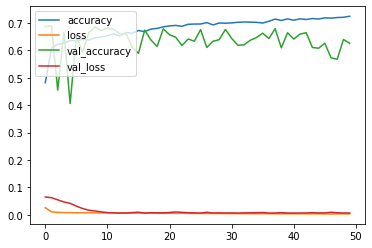

In [34]:
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc='upper left')
plt.show()

In [35]:
res = model2.predict(test_lab_images[1:2][..., 0:1])

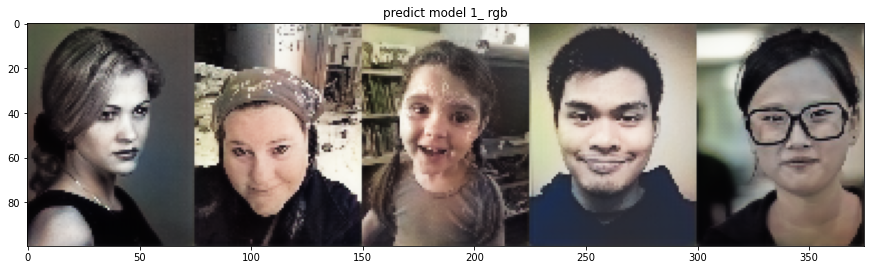

In [37]:
plt.figure(figsize=(15, 5))
five1 = model.predict(test_gray_images[10:15])
plt.imshow(np.hstack(five1))
plt.title('predict model 1_ rgb')
plt.show()

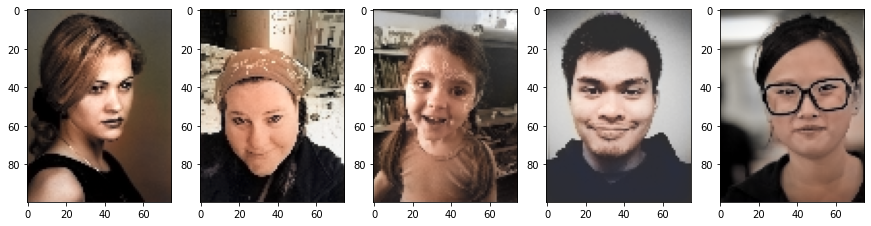

In [38]:
plt.figure(figsize=(15, 5))


def l2rgb(imgArr):
    pred_ab = model2.predict(np.expand_dims(imgArr, 0))
    pred_img = np.zeros((100, 75, 3))

    pred_img[:, :, 0] = imgArr.reshape((100, 75))
    pred_img[:, :, 1:] = pred_ab[0]

    pred_lab = (pred_img * [100, 255, 255]) - [0, 128, 128]
    rgb_img = color.lab2rgb(pred_lab)
    return rgb_img


for cnt, x in enumerate(range(10, 15)):
    plt.subplot(1, 5, cnt + 1)
    plt.imshow(l2rgb(test_lab_images[x][..., 0]))

In [39]:
test_images[10].min(), test_images[10].max()

(0.0, 0.9794117647058828)

In [42]:
np.shape(test_images), test_images.min(), test_images.max()

((300, 100, 75, 3), 0.0, 1.0)

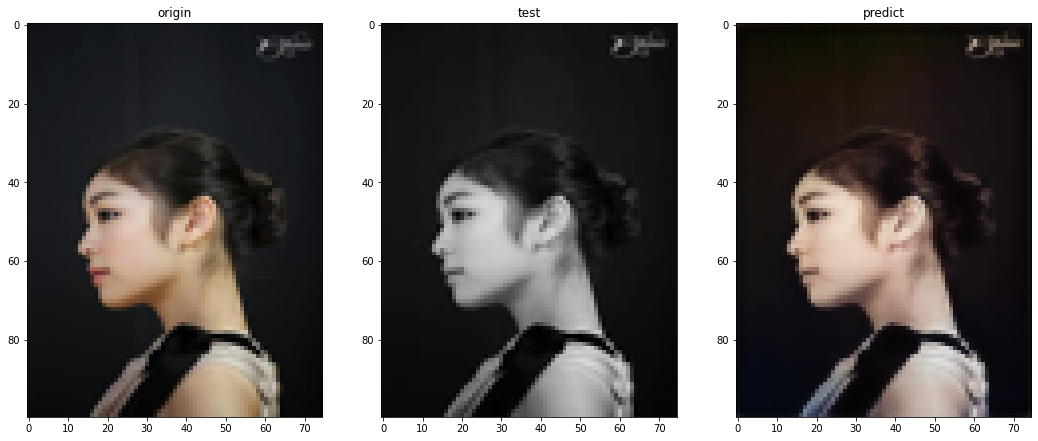

In [60]:
from PIL import Image

plt.figure(figsize=(18, 10))

origin = Image.open('images/kya-original.jpg')
origin = origin.resize((75, 100))
origin = np.array(origin)
plt.subplot(1, 3, 1)
plt.title('origin')
plt.imshow(origin)

my_img = Image.open('images/kya-gray.jpg')
my_img = my_img.resize((75, 100))
my_img = np.array(my_img)
plt.subplot(1, 3, 2)
plt.title('test')
plt.imshow(my_img)

my_img = np.array([color.rgb2lab(my_img)])
my_lab_img = np.array([(my_img[0] + [0, 128, 128]) / [100., 255., 255.]])
result = model.predict(my_lab_img[..., 0:1])

plt.subplot(1, 3, 3)
plt.title('predict')
plt.imshow(result[0])

plt.show()